# Daily rainfall data for France

## Data importation

We focus on 2 locations in France: Marseille and Strasbourg

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import approxbayescomp as abc
import numpy as np
import plotly.express as px
import seaborn as sns
from rain import pmom_poisson_gamma, simulate_precipitation
from numpy.polynomial.polynomial import Polynomial

# Figure 1: daily rainfals in Strasbourg

2000-01-01 00:00:00 2023-12-31 00:00:00


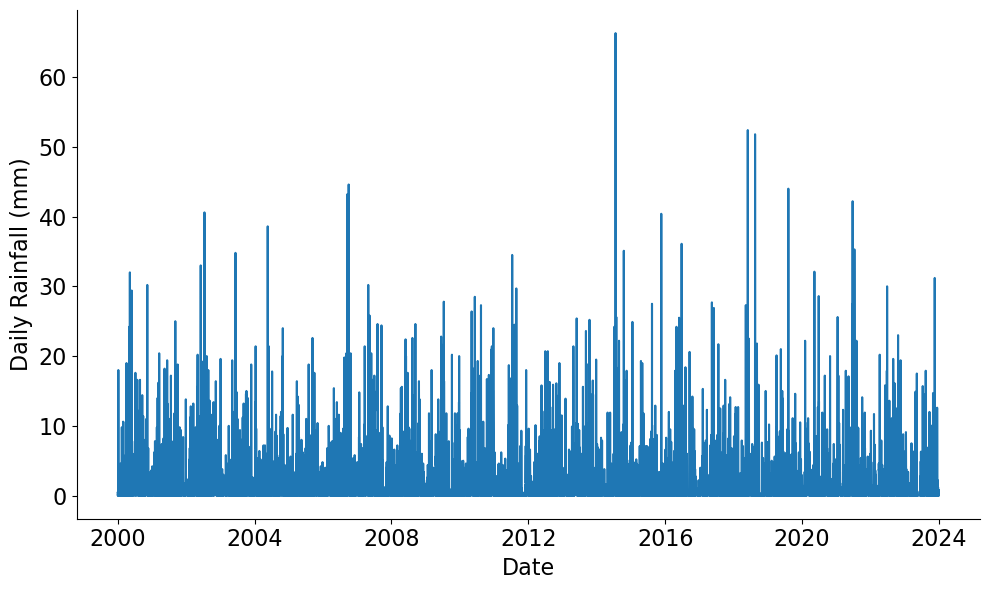

In [11]:
rain_df = pd.read_csv('../../data/processed_rainfall_data.csv')
rain_df['Date'] = np.array(pd.to_datetime(rain_df['AAAAMMJJ'], errors='coerce'))
print(rain_df['Date'].min(), rain_df['Date'].max())
stations = ['MARSEILLE-MARIGNANE', 'STRASBOURG-ENTZHEIM']
station = 'STRASBOURG-ENTZHEIM'
rain_df = rain_df.drop(columns=['QRR'])
# Filter the data for a specific station
# station = stations[2]  # Change the index to select a different station
# Filter the data for a specific date range
start_date = '2000-01-01'
end_date = '2023-12-31'
rain_df['NOM_USUEL'] = rain_df['NOM_USUEL'].replace("MARIGNANE", "MARSEILLE-MARIGNANE")
rain_df['Month'] = rain_df['Date'].dt.month
rain_df_subset = rain_df[(rain_df['Date'] >= start_date) & (rain_df['Date'] <= end_date) & (rain_df['NOM_USUEL'] == station)]

plt.figure(figsize=(10, 6))
# plt.tick_params(axis='both', which='major', labelsize=14)
plt.plot(rain_df_subset['Date'], rain_df_subset['RR'], label='Daily Rainfall')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Daily Rainfall (mm)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sns.despine()

plt.tight_layout()
plt.savefig('../../figures/ts_rainfall_strasbourg.pdf')
plt.show()



Monthly stat of the precipitation height, we compute the mean of the precipitation height and the proportion of days without rain for each month, each year and each location

# Compound Poisson Model and Partial Method of Moments calibration

We fit a compound $Q\sim\text{Poisson}(\lambda) - \text{gamma}(\alpha, \beta)$ model (Tweedie) for the cumulative precipitation in a day for each combination of month and location. We use the follwing formulas to estimate the parameters using the partial method of moments. 

 $\hat{\lambda}= -\log(\hat{p}_0),$ where $\hat{p}_0$ is an estimation of the proportion of days without rain episodes. We further have 
 $$
 \hat{\alpha} = \frac{\mu^2}{\hat{\lambda}\sigma^2 - \mu^2}\text{ and }\hat{\beta} = \frac{\mu}{\hat{\lambda}\hat{\alpha}}.
 $$


In [12]:
months = np.arange(1, 13, 1)
# Fit the model to the data using ABC
res_pmom_fits = []
for month in months:
    for station in stations:
        # print(f"Month: {month}, Station: {station}")
        obsData = rain_df[(rain_df['Month'] == month) & (rain_df['NOM_USUEL'] == station)]['RR'].tolist()
        lambda_hat, alpha_hat, beta_hat = pmom_poisson_gamma(obsData)
        res_pmom_fits.append({"station": station, 
                             "month": month, 
                             "lam": lambda_hat,
                             "alpha": alpha_hat,
                             "beta": beta_hat}
                             )
res_pmom_fits_df = pd.DataFrame(res_pmom_fits)
res_pmom_fits_df.to_csv('../../data/compound_poisson_models_pmom.csv', index=False)
res_pmom_fits_df.head()

,station,month,lam,alpha,beta
0,MARSEILLE-MARIGNANE,1,0.284104,0.324472,13.698380
1,STRASBOURG-ENTZHEIM,1,0.693147,0.422890,4.337758
2,MARSEILLE-MARIGNANE,2,0.261480,0.600542,6.737359
3,STRASBOURG-ENTZHEIM,2,0.600253,0.626834,3.061105
4,MARSEILLE-MARIGNANE,3,0.247290,0.314405,11.973267


# Figure 2: Plot of the number of rain episodes and their intensity depending on the month

STRASBOURG-ENTZHEIM


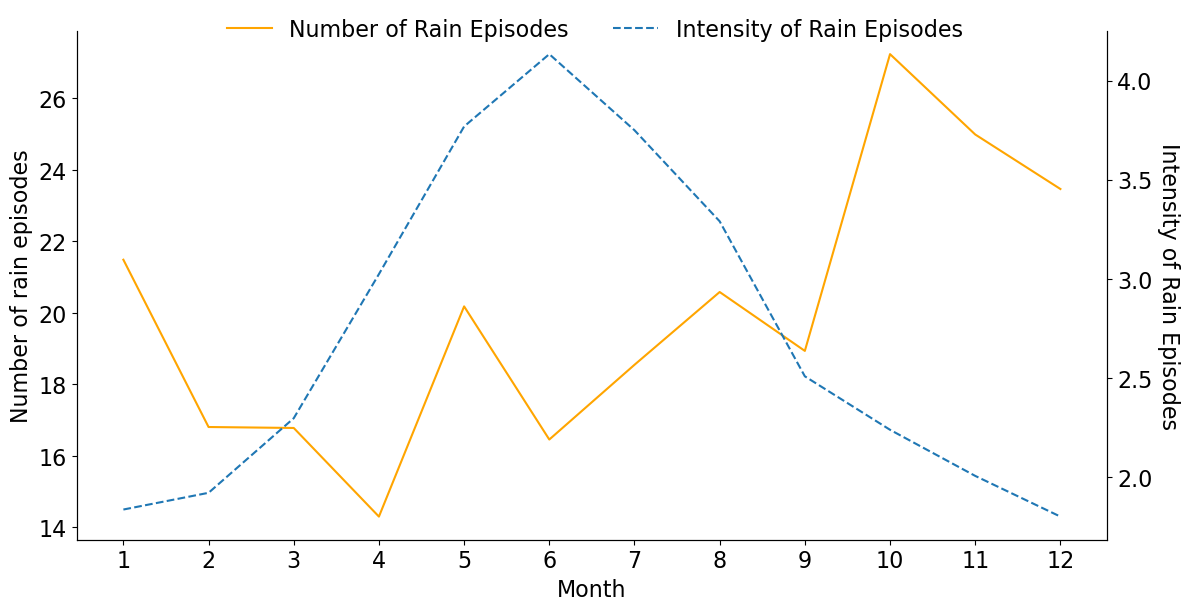

In [14]:
import warnings

warnings.filterwarnings('ignore')

subset = res_pmom_fits_df[res_pmom_fits_df['station'] == station]
print(station)
subset['days_in_month'] = subset['month'].apply(lambda m: 31 if m in [1, 3, 5, 7, 8, 10, 12] else (30 if m in [4, 6, 9, 11] else 28))
subset["rainy_days"] = subset['days_in_month'] * subset['lam']
subset["intensity_rain_episodes"] = subset['alpha'] * subset['beta']

fig, ax1 = plt.subplots(figsize=(12, 6))
# Plot the number of rainy days
# color = 'tab:blue'
ax1.set_xlabel('Month', fontsize=16)
ax1.set_ylabel('Number of rain episodes', fontsize=16)
ax1.plot(subset['month'], subset['rainy_days'], label='Number of Rain Episodes', color='orange')
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.set_xticks(subset['month'])

# Create a second y-axis for the intensity of rain episodes
ax2 = ax1.twinx()

ax2.set_ylabel('Intensity of Rain Episodes', fontsize=16, rotation=270, labelpad=20)
ax2.plot(subset['month'], subset['intensity_rain_episodes'], label='Intensity of Rain Episodes', linestyle='--')
ax2.tick_params(axis='y', labelsize=16)

fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.03), fontsize=16, ncol=2, frameon=False)
sns.despine(right=False)
plt.tight_layout()

plt.savefig(f'../../figures/rainy_days_and_rain_episode_intensity_strasbourg_by_month.pdf')
plt.show()


# Figure 3: Estimation of $\theta = \mathbb{P}(Q_t > \overline{Q})$ depending on the month and threshold $\overline{Q}$

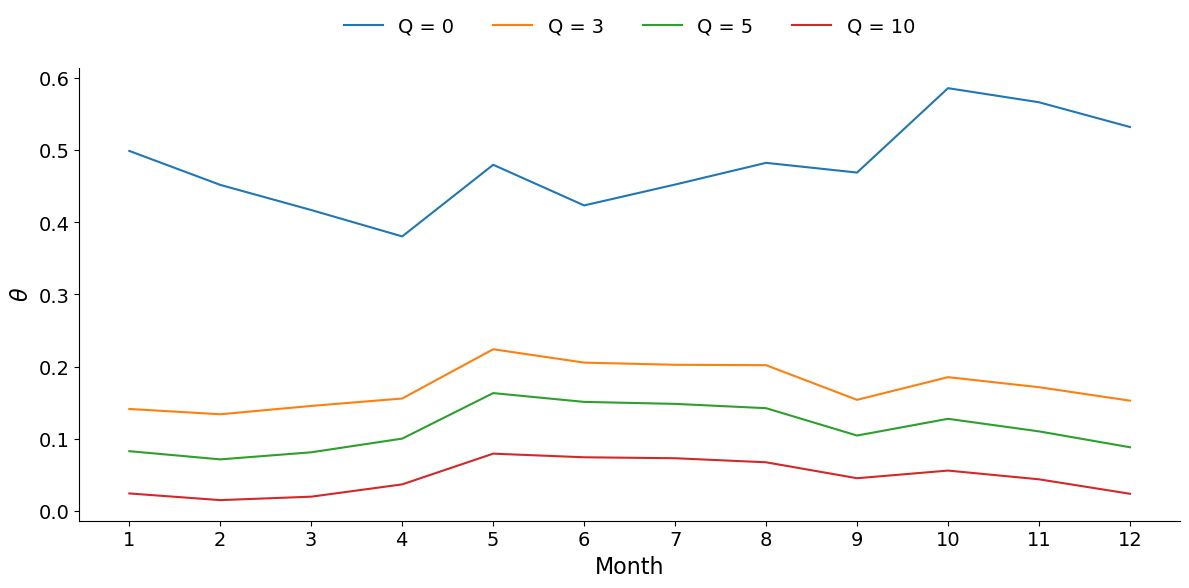

In [15]:
subset = res_pmom_fits_df[res_pmom_fits_df['station'] == station]
triggering_event_probability = []
for _, row in subset.iterrows():
    theta = row.lam, row.alpha, row.beta
    Q_sample = simulate_precipitation(theta, 100000)
    triggering_event_probability.append(
        pd.DataFrame({
        'month':row.month,
        'Q': [0, 3, 5, 10],
        'theta': [np.mean(Q_sample > Q) for Q in [0, 3, 5, 10]]
    })
    )
triggering_event_probability_df = pd.concat(triggering_event_probability, ignore_index=True)
plt.figure(figsize=(12, 6))
for Q in [0, 3, 5, 10]:
    subset_Q = triggering_event_probability_df[triggering_event_probability_df['Q'] == Q]
    plt.plot(subset_Q['month'], subset_Q['theta'], label=f'Q = {Q}')

plt.xlabel('Month', fontsize=16)
plt.ylabel(r'$\theta$', fontsize=16)
plt.xticks(ticks=np.arange(1, 13, 1), labels=np.arange(1, 13, 1), fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=14, ncol=4, frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig(f'../../figures/theta_strasbourg_by_month.pdf')
plt.show()


# Figure 4: Polynomial approximation for $\overline{Q} = 5$ and both stations

[ 7.57952309e-02 -3.04023830e-04  1.31045780e-05 -6.73157890e-08
  9.30192625e-11]


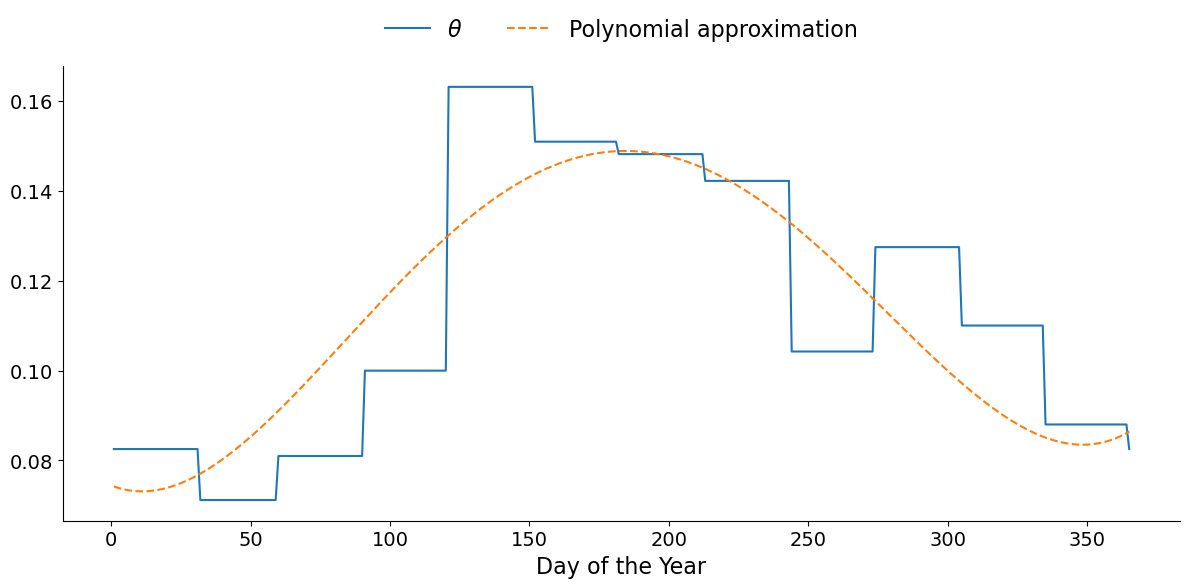

In [16]:
degree = 4
all_dates_2025 = pd.DataFrame({
    'date': pd.date_range(start='2025-01-01', end='2025-12-31', freq='D'),
    'index': range(1, 366)
})
prob = triggering_event_probability_df[triggering_event_probability_df['Q'] == 5]
prob['date'] = pd.date_range(start='2025-01-01', periods=len(prob), freq='MS')
prob = pd.concat([prob, prob.iloc[[0]].assign(date=pd.Timestamp('2025-12-31'))], ignore_index=True)
prob = pd.merge(prob, all_dates_2025 , on='date', how='left')
print(Polynomial.fit(prob['index'], prob['theta'], degree).convert().coef)
poly_coeffs = np.array([7.44408365e-02, -2.47370892e-04 , 1.22126822e-05, -6.31438744e-08, 8.70902681e-11])

def theta_polynomial(T):
    return np.polyval(poly_coeffs[::-1], T)
def theta_piecewise(index):
    global prob
    prob = prob.sort_values(by='index')
    index_values = prob['index'].values
    theta_values = prob['theta'].values
    if index < index_values[0] or index > index_values[-1]:
        raise ValueError("Index out of range")
    # Find the corresponding theta value
    for i in range(len(index_values) - 1):
        if index_values[i] <= index < index_values[i + 1]:
            return theta_values[i]
        if index == index_values[-1]:
            return theta_values[-1]

Ts = np.arange(1, 366, 1)
theta_values_piecewise = [theta_piecewise(t) for t in Ts]
theta_values_polynomial = [theta_polynomial(t) for t in Ts]
plt.figure(figsize=(12, 6))
plt.plot(Ts, theta_values_piecewise, label=r'$\theta$', linestyle='-')
plt.plot(Ts, theta_values_polynomial, label=f'Polynomial approximation', linestyle='--')
plt.xlabel('Day of the Year', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=16, ncol=2, frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig(f'../../figures/theta_piecewise_{station.lower().replace(" ", "_")}.pdf')
plt.show()


# Figure 5: Location of Strasbourg and Marseille in France

FileNotFoundError: [Errno 2] No such file or directory: '../figures/map_france_with_distances.pdf'

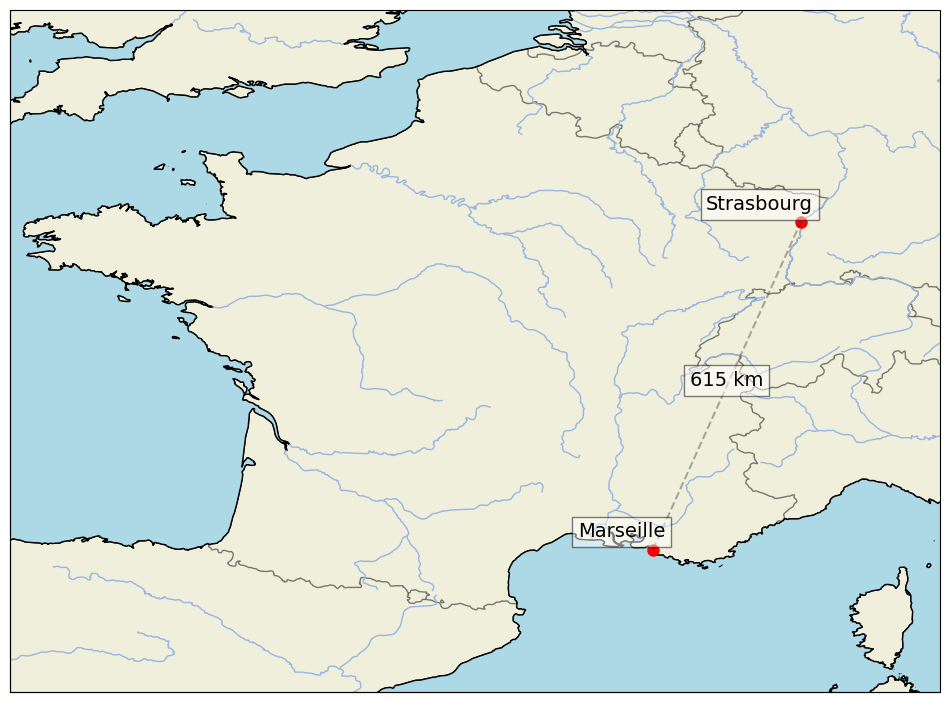

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from math import radians, cos, sin, sqrt, atan2

# Function to calculate the Haversine distance between two points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# Add natural features
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.RIVERS)

# Set the extent to focus on France
ax.set_extent([-5, 10, 41, 52], crs=ccrs.PlateCarree())

# Define the cities and their coordinates
cities = {
    # "Lorient": (47.748376, -3.366498),
    "Marseille": (43.296482, 5.369780),
    # "Lyon": (45.764043, 4.835659),
    "Strasbourg": (48.573405, 7.752111)
}

# Plot the cities
for city, (lat, lon) in cities.items():
    ax.plot(lon, lat, 'ro', markersize=8, transform=ccrs.Geodetic())
    ax.text(lon + 0.2, lat + 0.2, city, transform=ccrs.Geodetic(), fontsize=14, ha='right', bbox=dict(facecolor='white', alpha=0.5))

# Calculate and annotate distances between cities
city_list = list(cities.keys())
for i in range(len(city_list)):
    for j in range(i + 1, len(city_list)):
        city1 = city_list[i]
        city2 = city_list[j]
        lat1, lon1 = cities[city1]
        lat2, lon2 = cities[city2]
        distance = haversine(lat1, lon1, lat2, lon2)
        mid_lat = (lat1 + lat2) / 2
        mid_lon = (lon1 + lon2) / 2
        ax.plot([lon1, lon2], [lat1, lat2], 'k--', transform=ccrs.Geodetic(), alpha=0.3)
        ax.text(mid_lon, mid_lat, f"{distance:.0f} km", transform=ccrs.Geodetic(), fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=0.5))

# Remove gridlines and labels
# ax.gridlines(draw_labels=False)
ax.grid(False)
sns.despine()
# Save the plot as a PDF
plt.savefig("../figures/map_france_with_distances.pdf", format="pdf", bbox_inches='tight')

# Show the plot
plt.show()


# Figure 6: Probability of the triggreing event in Marseille and Strasbourg as a function of the day of the year

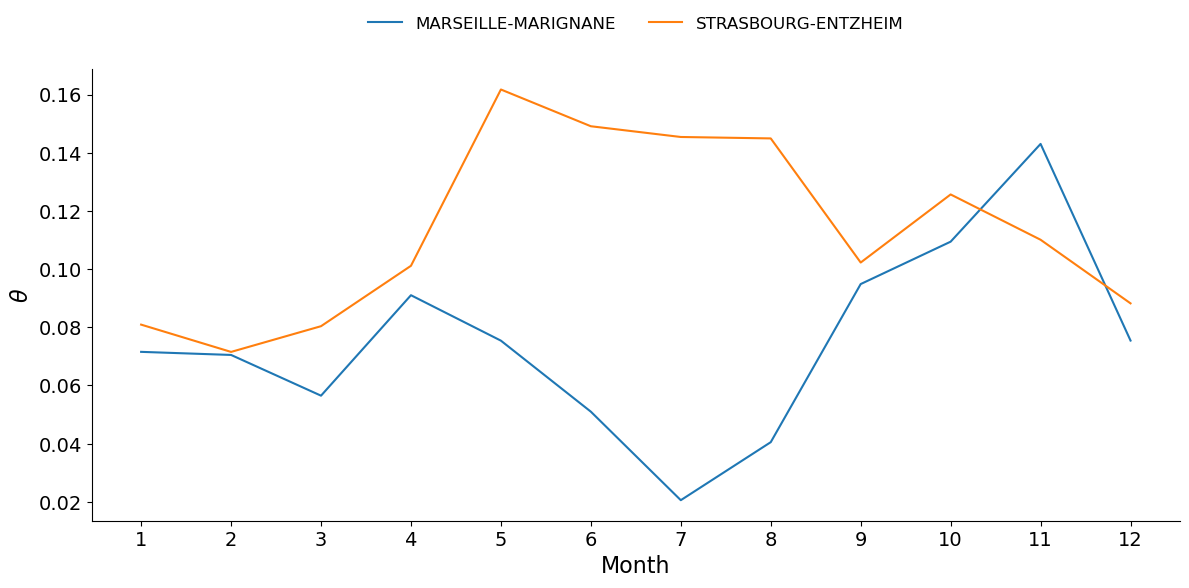

In [19]:
triggering_event_probability = []
stations = ["MARSEILLE-MARIGNANE", "STRASBOURG-ENTZHEIM"]
Q_bar = 5

for _, row in res_pmom_fits_df.iterrows():
    theta = row.lam, row.alpha, row.beta
    Q_sample = simulate_precipitation(theta, 100000)
    triggering_event_probability.append(
        pd.DataFrame({
        'station': row.station,
        'month':row.month,
        'Q':  [Q_bar],
        'theta': [np.mean(Q_sample > Q_bar)]
    })
    )
triggering_event_probability_df = pd.concat(triggering_event_probability, ignore_index=True)
plt.figure(figsize=(12, 6))
for station in stations:
    subset_station = triggering_event_probability_df[triggering_event_probability_df['station'] == station]
    plt.plot(subset_station['month'], subset_station['theta'], label=station)

plt.xlabel('Month', fontsize=16)
plt.ylabel(r'$\theta$', fontsize=16)
plt.xticks(ticks=np.arange(1, 13, 1), labels=np.arange(1, 13, 1), fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=12, ncol=4, frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig(f'../../figures/theta_by_station_by_month.pdf')
plt.show()